In [3]:
import numpy as np
!pip install hmmlearn
from hmmlearn import hmm
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.0 MB/s eta 0:00:00


!pip install hmmlearn - command needed to install hmmlearn library on colab/jupyter
Library hmmlearn: https://hmmlearn.readthedocs.io/en/latest/index.html

There are few possible models in hmmlearn library:


*   Hidden Markov Model with categorical (discrete) emissions.
*   Hidden Markov Model with Gaussian emissions.
*   Hidden Markov Model with Gaussian mixture emissions.
*   Hidden Markov Model with multinomial emissions.
*   Hidden Markov Model with Poisson emissions.
*   Hidden Markov Model with categorical (discrete) emissions trained using Variational Inference.
*   Hidden Markov Model with Multivariate Gaussian Emissions trained using Variational Inference.
*   Hidden Markov Model with a custom emission probability.











In [4]:
model = hmm.CategoricalHMM(n_components=2, random_state=99)

In this case when we create CategoricalHMM we have following arguments:
*   n_components (int) – Number of states.
*   random_state (RandomState or an int seed, optional) – A random number generator instance.

This mean that we are making model with two states which in our case are real die and fake die.



---



In [5]:
model.startprob_ = np.array([1.0, 0.0])

startprob (array, shape (n_components, )) – Initial state occupation distribution. Should always sum up to 1.0

This method is telling the model that we are starting with at the first state, in our case real die.


---



In [6]:
model.transmat_ = np.array([[0.5, 0.5], [1, 0]])

transmat (array, shape (n_components, n_components)) – Matrix of transition probabilities between states.

Using this method we can specify models behaviour in each state. In our case we are telling model that:<br><br>
  In state_1 we have:

  *   50% to stay in state_1
  *   50% to change state to state_2

In state_2 we have:

  *   100% to change state to state_1



---





In [7]:
model.emissionprob_ = np.array([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6], [1 / 6, 1 / 6, 1 / 6, 0, 0, 0.5]])

emissionprob (array, shape (n_components, n_features)) – Probability of emitting a given symbol when in each state.

In this method we are telling the model how it behave in each state. We are giving a probabilities for each die. Real die have probabilities from first array: **[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6]** and fake one have probabilities from second array: **[1 / 6, 1 / 6, 1 / 6, 0, 0, 0.5]**

----


In [8]:
rolls, gen_states = model.sample(30000)

Rolls - feature matrix

gen_states = state sequence produced by the model

This code is simulating dices rolls over 30000 steps. As a result we are getting two things:
1. Simulated probabilities for rolls on each die
2. How states were changing (state_1 <-> state_2)
---

In [9]:
print("Limiting distribution: " + str(model.get_stationary_distribution()))

Limiting distribution: [0.66666667 0.33333333]


Above we got limiting distribution after simulation. It is equal to the limiting distribution we got at the lecture.

---

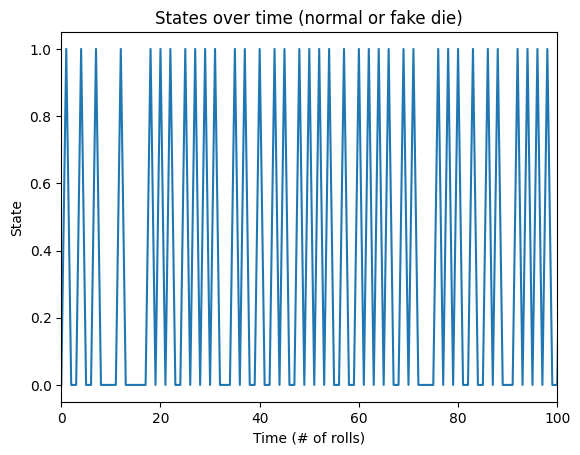

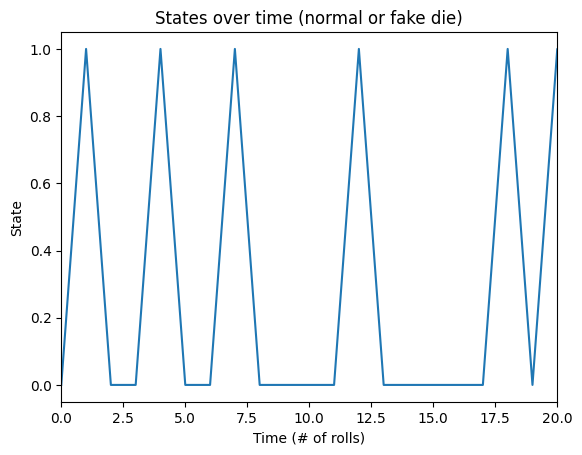

In [11]:
fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('States over time (normal or fake die)')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
plt.xlim([0, 100])
plt.show()

fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('States over time (normal or fake die)')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
plt.xlim([0, 20])
plt.show()

In graphs above we printed how states were changing. We can see that there is no pattern in changing states. Model never stays in state_2 which is correct behaviour.

---

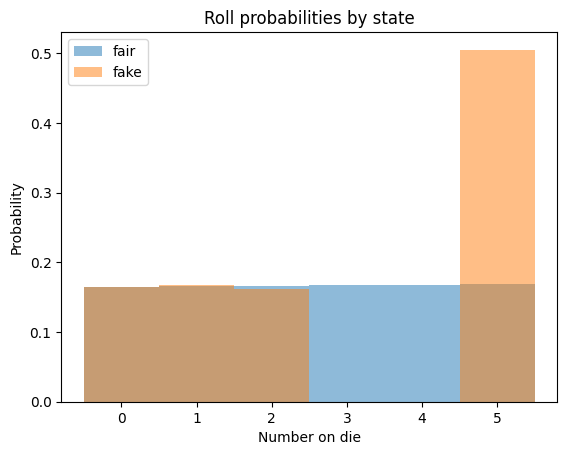

In [ ]:
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='fake', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.set_title('Roll probabilities by state')
ax.set_xlabel('Number on die')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

Above graph presents probabilities of rolls in each state. Those values are calculated from simulation. Analising graph we can see that in state_2 there is 0% chance for roll 4 and 5 which is correct.

### EXTRA


---
Recover of hidden states

In [13]:
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

Dividing into two sets for ML. Half of our previous result will be used to learn model and regenerate transmission matrix and rest will be used to validate those results.


---



In [16]:
gen_score = model.score(X_validate)
print(f'Model optimal score: {gen_score}')

Model optimal score: -26009.950420890396


Checking optimal score. This will be used to find the best model for regenerate transmission matrix.

In [15]:
best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    rec_model = hmm.CategoricalHMM(n_components=2, random_state=idx, init_params='se')
    #init_params (string, optional) – The parameters that get updated during (params) or initialized before (init_params) the training. Can contain any combination of ‘s’ for startprob, ‘t’ for transmat, and ‘e’ for emissionprob. Defaults to all parameters.
    rec_model.transmat_ = np.array([np.random.dirichlet([0.2, 0.8]), np.random.dirichlet([0.5, 0.5])])
    rec_model.fit(X_train)
    score = rec_model.score(X_validate)
    #print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = rec_model
        best_score = score

Code above is making new models and comparing them with optimal model.
We are using fit method to estimate models parameters. Then we are calculating its score and compare it. This way we can find the best fit for regeneration.

---

In [ ]:
# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = best_model.predict(rolls)

Method predict uses Viterbi algorithm to find most likely sequence. Viterbi algorithm is complicated  This is slow approach because we are workin on a single sample at a time.


---



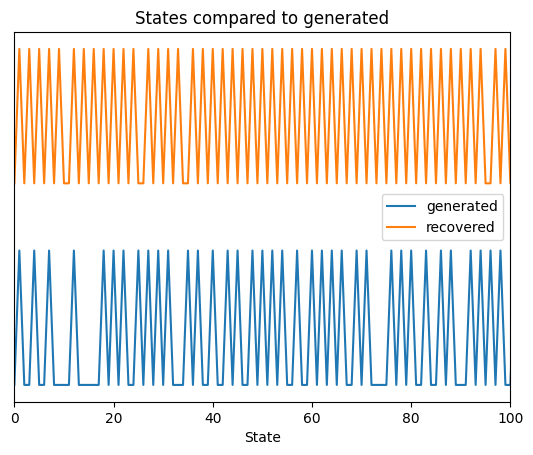

In [ ]:
# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(states[:500] + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
plt.xlim([0, 100])
ax.legend()
fig.show()

We can see that our recover changing of states isn't exactly the same. But we can print out how transmission matrix looks


---



In [ ]:
print(f'Transmission Matrix Generated:\n{model.transmat_.round(3)}\n\n'
      f'Transmission Matrix Recovered:\n{best_model.transmat_.round(3)}\n\n')

Transmission Matrix Generated:
[[0.5 0.5]
 [1.  0. ]]

Transmission Matrix Recovered:
[[0.376 0.624]
 [0.999 0.001]]




As we can see our recovered transmission matrix is different. Probabilities of staying in state_1 and changing to state_2 are changed. This caused diffrences in our graph. 

---

In [ ]:
print(f'Emission Matrix Generated:\n{model.emissionprob_.round(3)}\n\n'
      f'Emission Matrix Recovered:\n{best_model.emissionprob_.round(3)}\n\n')

Emission Matrix Generated:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.167 0.167 0.167 0.    0.    0.5  ]]

Emission Matrix Recovered:
[[0.156 0.167 0.179 0.166 0.147 0.185]
 [0.171 0.166 0.141 0.027 0.054 0.441]]




We can also see difference in emission matrix. Differences are smaller than in transmission matrix but still can impact our results. 

This library gives us many options and possibilities.